# Speedrunning Model Training
(includes `pytorch-lightning`!!)  

More often than not, you'll want to train your models as soon as possible. Maybe you're in a competition, or you're testing an architecture preliminarily, or maybe you're just really lazy. So, how can we squeeze the most time out of what we have?  

This is a list of techniques to use, one by one, to see how much we can improve training time by. We evalutate our techniques by training ResNet18 from scratch on CIFAR-10 for 10 epochs.  

Much of the techniques below were taken from the sources below:  
https://www.reddit.com/r/MachineLearning/comments/kvs1ex/d_here_are_17_ways_of_making_pytorch_training/  
https://lightning.ai/pages/community/tutorial/how-to-speed-up-pytorch-model-training/

In [1]:
import torch
import torch.nn as nn
import torchvision

### The Baseline
Here, we just import CIFAR-10 and apply some augmentations. Nothing special!

In [2]:
import torchvision.transforms as transforms

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
])
test_transforms = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
])

train_ds = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=train_transforms)
test_ds = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=test_transforms)

In [4]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

As mentioned above, we use ResNet18. TorchVision provides the architecture for us, and in this case, we do not load any pretrained weights as we want to train it from scratch.

In [5]:
from torchvision.models import resnet18

In [6]:
model = resnet18()

I'm gonna use PyTorch Lightning because, well, I'm a lazy person - and it's addictive how lazy you can get using Lightning. Just plug in your module and let the framework handle the training for you!

In [7]:
import pytorch_lightning as pl
import torchmetrics

In [8]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.lr = lr

        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.resnet.parameters(), lr=self.lr)

model = LResNet(resnet18, 3e-4)

Above I set the learning rate to `3e-4` - which is safe for most models using Adam-based optimizers. Reference https://karpathy.github.io/2019/04/25/recipe/ for more tricks like this!  

In [9]:
%%time
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 5060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 36s, sys: 4.71 s, total: 1min 41s
Wall time: 1min 38s


On this RTX 5060Ti that I'm renting, I get ~161it/s, and training the entire thing takes 1m 38s. You can expand the cell above to see the exact specs.  

Let's see our accuracy...

In [10]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7574999928474426     │
│         val_loss          │    0.7050080299377441     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7050080299377441, 'val_acc': 0.7574999928474426}]

Wow, 75%! That's honestly really good, and will be hard to beat.  

With that, let's start with how to make the model train faster.

### Method -1: Listen to Lightning

It's called -1 because you don't really do anything. Lightning complains that a setting isn't set properly, and most of the time its best to just follow.

In [11]:
torch.set_float32_matmul_precision('high')

Gonna do a quick test of the speed to test it now...

In [12]:
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_epochs=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


It's about 3it/s faster, just by listening to the framework!

### Method 0: Initialize Properly
I'm not stalling for time - this is something we *should* have done, but didn't! It can make surprising differences to the performance of the model.  

Since we're using a modern neural network with ReLU activations, we use Kaiming initialization for the weights. If your network uses sigmoid or tanh activations, you should use Xavier initialization instead.  

All biases are initialized to zero, and BatchNorm layers (as per all normalization layers) should have their weights set to one and bias to zero.

In [13]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.lr = lr

        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)
        
        ###################################################################################################################
        # NEW! Apply the weight initialization function. You can look at the torch docs for the .apply method to know more.
        self.apply(self._init_weights)
        ###################################################################################################################

    #######################################################################################################################
    # NEW! The initialization function itself. The markdown block above should have explained the reasoning it well enough.
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    #######################################################################################################################

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.resnet.parameters(), lr=self.lr)

Let's run the model and see how it performs now.

In [14]:
%%time
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 1min 36s, sys: 4.47 s, total: 1min 40s
Wall time: 1min 37s


In [15]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7465999722480774     │
│         val_loss          │    0.7528039216995239     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7528039216995239, 'val_acc': 0.7465999722480774}]

The accuracy dropped a bit - but given between the first run and this had zero architectural or training changes, I'd say this is within the margin of error.

### Method 1: Increase Batch Size

Maxing out the batch size is age-old advice. However, you **must** consider several factors.
1. The higher your batch size, the lower your accuracy. In settings where you want to maximize the accuracy, massively large batch sizes (>1024 is a safe estimate) will *significantly* tank your accuracy.
2. Make sure that you have enough batches left in your dataset. It's tempting to push for huge batch sizes as in research, but keep in mind that we're working with different amounts of data. They have, at least in ImageNet, *millions* of images. We have 50,000 in CIFAR.

I've devised a method, illustrated below, to find an ideal batch size in a time-constrained scenario. We can use the `max_time` parameter of Lightning's trainer to test how much the model learns in 1 minute.  

First, let's test the original batch size of 32 under these constraints.

In [24]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


In [25]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7067999839782715     │
│         val_loss          │    0.8377194404602051     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8377194404602051, 'val_acc': 0.7067999839782715}]

70%... a big step down. This is a sign that the batch size is too low, leading to inefficient use of the GPU.

Let's start with 128, or four times the initial value of 32.

In [16]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2)
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

In [17]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7347999811172485     │
│         val_loss          │    0.8384631872177124     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8384631872177124, 'val_acc': 0.7347999811172485}]

73% is quite acceptable - we can easily gain those more percents back to hit 75% if we trained for as long as the initial training, which took 1m 30s!  

Onwards to 512, four times 128.

In [18]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2)
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

In [19]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6686999797821045     │
│         val_loss          │    1.0391274690628052     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.0391274690628052, 'val_acc': 0.6686999797821045}]

Now that's far below 70% - a score we can't accept, as it will take a lot of tuning to get it back to where we want it.  

In the spirit of binary search, let's find a value in between that works. We start with 256, the number between 128 and 512.

In [20]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2)
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

In [21]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7149999737739563     │
│         val_loss          │    0.8798918128013611     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8798918128013611, 'val_acc': 0.7149999737739563}]

71% isn't the worst, but 128 is still better. Let's try 64 to see if it offers a better balance.

In [22]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:00", check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


In [23]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.741599977016449     │
│         val_loss          │    0.7896497845649719     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7896497845649719, 'val_acc': 0.741599977016449}]

74% is brilliant! We'll take that offer, and proceed with this batch size for the rest of the notebook.

#### Optimizing Dataloaders for Performance

I'll explain the important hyperparameters for PyTorch's `DataLoader` below:
- `num_workers`: The number of threads to spawn for loading the data. Note that Python is pretty finnicky about multiprocessing, so if you ever run into deadlocks (i.e. training hangs) try reducing this value, reducing the number of logging/print statements, or simply waiting a bit longer.
- `pin_memory`: Keeps the data pinned in memory. Sometimes this works for me, other times it seems that the data isn't pinned or I keep getting OOM errors. The general advice is to keep this enabled unless you really cannot.
- `prefetch_factor`: For each worker/thread, it will try to prep `prefetch_factor` batches of data the moment the DataLoader is initialized. Then, every time a batch is consumed by the model, it will try to once prep batches up to the indicated size. Try to keep `num_workers * prefetch_factor` less than your total number of batches, or you'll be wasting effort. Mostly applicable for massive batch sizes.
- `persistent_workers`: If true, PyTorch will reuse threads and not create new ones each epoch. This is good if you notice that at the start of each epoch, it takes a long time to load the first batch (since creating a thread takes time) and is more useful when you have massive batch sizes.

In [27]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=3, prefetch_factor=1, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=3, prefetch_factor=1, persistent_workers=True)

However, we can try to optimize this even further. Observe how long it takes to fetch a single example.

In [28]:
%%timeit
len(next(iter(train_loader))[0])

24.4 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It takes *~3s* just to load, resize, augment, and normalize more than 16,000 images. A GPU takes just a fraction (okay maybe just 1/2) of that time to process that!  

Thankfully, there's a way to do this - parallelizing the transformations on the GPU. Operations on large amounts of data is much faster there, thus we minimize augmentations done on the CPU to the bare minimum. In our case, we do the *literal* bare minimum of converting the images from PIL format to Tensor.  

We also use v2 TorchVision transforms, which should be slightly faster. I've heard that it also added support for GPU transforms, but I can't find a reliable source for that.

In [29]:
from torchvision.transforms import v2

img_transforms = v2.Compose([
    v2.ToImage(),
])

train_ds = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=img_transforms)
test_ds = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=img_transforms)

Now, if we see how long loading one batch takes...

In [30]:
# Redefine the classes to use the new train_ds and test_ds definitions
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=3, prefetch_factor=1, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=3, prefetch_factor=1, persistent_workers=True)

In [31]:
%%timeit
len(next(iter(train_loader))[0])

14.8 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


It takes just about a second. I'm too lazy to pull out a calculator, but that's a 3x speedup.  

Read the comment blocks in the code below which highlight the changes made for GPU augmentation.

In [32]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.lr = lr
        
        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

        ######################################
        # NEW! We put the augmentations here.
        self.img_scale = v2.ToDtype(torch.float32, scale=True)
        self.img_norm = v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
        self.img_aug = v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10)
        ######################################

        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def training_step(self, batch, batch_idx):
        X, y = batch
        ##########################################################################
        # NEW! We apply the normalization, scale, and augmentation for training...
        X = self.img_norm(self.img_scale(self.img_aug(X)))
        ##########################################################################
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        #########################################################
        # NEW! We apply only normalization and scale for testing.
        X = self.img_norm(self.img_scale(X))
        #########################################################
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.resnet.parameters(), lr=self.lr)

Let's validate the speed improvements by running data through it.

In [15]:
%%time
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_epochs=2, log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


CPU times: user 4.24 s, sys: 344 ms, total: 4.58 s
Wall time: 6.11 s


About 1.6it/s! Before, it was only about 0.8it/s.  

Now that we have a fairer pipeline for data, we can also illustrate how increasing the batch size reduces execution time.

In [25]:
# Testing with batch size 8192
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8192, shuffle=True, num_workers=3, pin_memory=True, prefetch_factor=2, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=8192, shuffle=False, num_workers=3, pin_memory=True, prefetch_factor=2, persistent_workers=True)

In [26]:
%%time
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_epochs=2, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789c69d63e20><function _MultiProcessingDataLoaderIter.__del__ at 0x789c69d63e20>
Traceback (most recent call last):

  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
      File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
self._shutdown_workers()
      File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

     if w.is_alive(): 
         ^^ ^ ^^ ^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

CPU times: user 3.48 s, sys: 320 ms, total: 3.8 s
Wall time: 4.6 s


The above, using a batch size of 8192, took 4.6s to execute, whiel the one using a batch size of 16384 only took 4.12s. Thus, we can confidently use the larger batch size for the rest of this notebook.

In [17]:
del train_loader, test_loader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16384, shuffle=True, num_workers=3, pin_memory=True, prefetch_factor=2, persistent_workers=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=16384, shuffle=False, num_workers=3, pin_memory=True, prefetch_factor=2, persistent_workers=True)

#### Accomodating for Larger Batches

How about training 10 epochs, then? 10 epochs may not be a fair value anymore.  

When training with a batch size of 32, we had `50000/32 = 1562.5` batches, which meant *~1500* `optimizer.step()`s, which is *~1500 more weight updates*. In contrast, we only have 4! And the last batch is barely a tenth of the intended size (which may actually mess with BatchNorm in the ResNet, so we drop the last batch above...) which means that we get a lot less meaning full updates in a single epoch, let alone in 10.  

A simple solution, however - why not just train that for more epochs to get to that number of gradient steps?  

Firstly, no, I will not train for 5120 epochs. That is a waste of time and unreasonable. I will, however, train for 1m38s - the same as the initial training. 

In [18]:
%%time
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_time="00:00:01:38", log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:38. Signaling Trainer to stop.


CPU times: user 1min 19s, sys: 870 ms, total: 1min 20s
Wall time: 1min 40s


In [19]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.48919999599456787    │
│         val_loss          │    1.4898457527160645     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.4898457527160645, 'val_acc': 0.48919999599456787}]

That's much worse than expected. The Tensorboard logging provides a clue - it's overfitting! It actually reached a peak accuracy of about 51% before dipping down to the current levels. In fact, I ran the code multiple times to ensure that the overfitting is not a fluke.  

This is a *massive* issue. In fact, we'll divert from the main topic of speedrunning to training process to focus on this.

### Diversion 1.5: Solving Overfitting with Large Batch Sizes
Our good friend ChatGPT provides compelling and accurate reasons for this:
> 1. **Less Gradient Noise → Less Regularization:** Small batches add noise to gradient updates, acting like a form of regularization. Large batches reduce this noise, making the model fit the training data more precisely—but often at the expense of generalization.
> 2. **Sharp Minima:** Large batches are prone to converge to sharp minima, which fit the training data very well but generalize poorly to unseen data.
> 3. **Effective Epochs Reduced:** With the same number of epochs or time, large batch training results in fewer weight updates, so you don’t get as many generalization-friendly updates from noisy gradients.
> 4. **Normalization and Regularization Mismatch:**
If you're using BatchNorm, it might behave differently (less noisy) with huge batches, weakening its regularizing effect.

A summary? Smaller batch sizes have *more noise* in their batches, which is a *form of regularization*. Larger batch sizes reduces that, and, as a a result of less regularization, we start *overfitting*.  

Since we're stuck with ResNet18, we can't do things like add dropout, although that would be ideal. Instead, let's experiment with other parameters.  

One parameter to tune is the **weight decay** of the optimizer. The higher the weight decay, the more the model is penalized for having *larger weights*. This in turn encourages the model not to focus on any one feature too much, reducing the effect of overfitting. The default is 1e-2, so we try 5e-2. (Fun fact: weight decay is *broken in Adam*, and AdamW introduces the fix!)

In [47]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, lr, weight_decay):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.lr = lr
        #################################
        # NEW! Add weight decay parameter
        self.weight_decay = weight_decay
        #################################
        
        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

        self.img_scale = v2.ToDtype(torch.float32, scale=True)
        self.img_norm = v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
        self.img_aug = v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10)

        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def training_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(self.img_aug(X)))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(X))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        #####################################
        # NEW! Add weight decay into optimizer
        return torch.optim.AdamW(self.resnet.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        #####################################

Let's run it through training. We can also increase the frequency of logging in Tensorboard (`check_val_every_n_epoch`) just to make sure I'm not seeing things wrong. 

In [26]:
%%time
model = LResNet(resnet18, 3e-4, 5e-2)
trainer = pl.Trainer(max_time="00:00:01:38", log_every_n_steps=1, check_val_every_n_epoch=2, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:38. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

CPU times: user 1min 14s, sys: 775 ms, total: 1min 15s
Wall time: 1min 40s


In [27]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5424000024795532     │
│         val_loss          │     1.301148772239685     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.301148772239685, 'val_acc': 0.5424000024795532}]

The result is slightly better - but still nowhere near the original score of ~75%.

Even with the same amount of time, we are unable to reach the same standards as before. So, what's the point of having a larger batch size?

### Method 2: Find a better Learning Rate
The purpose of a larger batch size is to find more accurate and less noisy gradients. After all, surely the average gradient provided by 16,000 samples is better than just 32. The issue is that if we don't capitalize on this more accurate gradient, all the effort will be put to waste.  

Thus, a larger learning rate is what best makes use of this gradient. Instead of taking many small and noisy steps, we take big and accurate steps towards the minima... as long as we don't overfit.  

Classical literature suggests that when you increase the batch size by K times, you increase the learning rate by sqrt(K) times. Since we have the computing resources, let's test the hypothesis out.

In [30]:
%%time
model = LResNet(resnet18, 3e-4*(512**0.5), 5e-2)
trainer = pl.Trainer(max_time="00:00:01:38", log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:38. Signaling Trainer to stop.


CPU times: user 1min 17s, sys: 784 ms, total: 1min 18s
Wall time: 1min 39s


In [31]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.399399995803833     │
│         val_loss          │    1.6764001846313477     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.6764001846313477, 'val_acc': 0.399399995803833}]

Yikes. That's pretty bad.  

To be fair, I also privately tested increasing it by K times, and performed only slightly better than random guessing. So this 'advice' cannot be trusted!

Now, if only there was a way for us to find a proper learning rate...

#### Lightning's `Tuner` for `lr_find`
Turns out, Lightning provides a `Tuner` class to help us find an optimal learning rate! The internal mechanisms for how it decides so is buried within piles of research (search up Leslie N. Smith, he has a lot of good papers on this topic!) so let's just start by using it.  

The `lr_find` function basically increases the learning rate slowly and records the loss for each of the values. It does this for `num_training` steps - which we manually define as the default of 100 steps would take more than a minute.

In [32]:
model = LResNet(resnet18, 3e-4, 5e-2)
trainer = pl.Trainer(max_time="00:00:01:38", log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
tuner = pl.tuner.Tuner(trainer)
results = tuner.lr_find(model, train_loader, test_loader, num_training=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
Learning rate set to 0.0013182567385564075
Restoring states from the checkpoint path at /workspace/CremeBrulee/.lr_find_585244c3-9512-4922-a735-fe3cf91ccf4b.ckpt
Restored all states from the checkpoint at /workspace/CremeBrulee/.lr_find_585244c3-9512-4922-a735-fe3cf91ccf4b.ckpt


We can plot the result of the learning rate sweep and the recommended value. Note that Lightning automatically modifies the model to use the recommended learning rate, so we won't have to bother more!

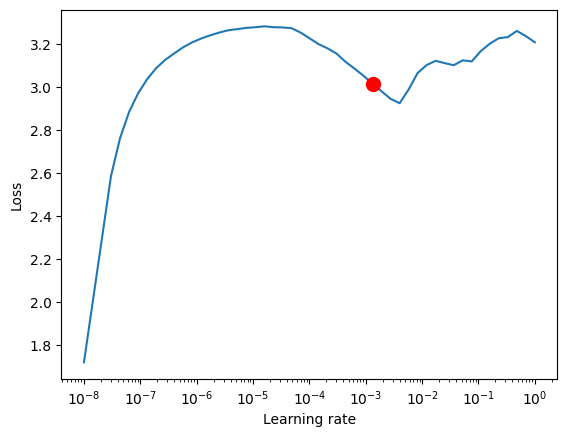

0.0013182567385564075

In [33]:
results.plot(suggest=True, show=True)
results.suggestion()

We see that the loss starts to decrease around 5e-5, and stops doing so around 2e-3. The model suggests somewhere in between, around the value of 1e-3.

These values will come in handy later. For now, let's just train the model with the recommended learning rate.

In [34]:
%%time
trainer.fit(model, train_loader, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:38. Signaling Trainer to stop.


CPU times: user 1min 18s, sys: 796 ms, total: 1min 19s
Wall time: 1min 39s


In [35]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6051999926567078     │
│         val_loss          │    1.1088993549346924     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.1088993549346924, 'val_acc': 0.6051999926567078}]

We did even better than last time! But we're still behind the 78% of the original model.  

There's one more thing we can try - adjusting the weight decay. Now that we're changing the learning rate, we can also check if changing the weight decay helps.

In [48]:
model = LResNet(resnet18, results.suggestion(), 1e-2)
trainer = pl.Trainer(max_time="00:00:01:38", log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:01:38. Signaling Trainer to stop.


In [49]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5135999917984009     │
│         val_loss          │    1.3973650932312012     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.3973650932312012, 'val_acc': 0.5135999917984009}]

Nope. On to the next method.

### Method 3: Using a Learning Rate Scheduler
We *should* be able to match 78% in this section.

In [36]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, max_lr, min_lr, weight_decay, epochs):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        #############################################################################
        # NEW! Accept epochs, max_lr and min_lr, to make configuring OneCycleLR less painful.
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.epochs = epochs
        #############################################################################
        self.weight_decay = weight_decay
        
        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

        self.img_scale = v2.ToDtype(torch.float32, scale=True)
        self.img_norm = v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
        self.img_aug = v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def training_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(self.img_aug(X)))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(X))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        #######################################
        # NEW! Use OneCycleLR as the scheduler.
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.min_lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr, epochs=self.epochs, steps_per_epoch=len(train_loader), div_factor=self.max_lr/self.min_lr)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]
        #######################################

In [37]:
%%time
model = LResNet(resnet18, 2e-3, 5e-5, 5e-2, 37)
trainer = pl.Trainer(max_epochs=37, log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=37` reached.


CPU times: user 1min 16s, sys: 755 ms, total: 1min 17s
Wall time: 1min 37s


In [38]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5781999826431274     │
│         val_loss          │    1.1918003559112549     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.1918003559112549, 'val_acc': 0.5781999826431274}]

Oh no - no improvement?? Luckily, there's a clear sign.

In [45]:
%%time
model = LResNet(resnet18, 2e-3, 5e-5, 1e-4, 37)
trainer = pl.Trainer(max_epochs=37, gradient_clip_val=0.5, log_every_n_steps=1, check_val_every_n_epoch=5, enable_checkpointing=False)
trainer.fit(model, train_loader, test_loader) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=37` reached.


CPU times: user 1min 16s, sys: 813 ms, total: 1min 17s
Wall time: 1min 39s


In [46]:
trainer.validate(model, test_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.659600019454956     │
│         val_loss          │    0.9695486426353455     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.9695486426353455, 'val_acc': 0.659600019454956}]

In [38]:
53.2/20

2.66

In [ ]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.lr = lr
        
        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

        self.img_scale = v2.ToDtype(torch.float32, scale=True)
        self.img_norm = v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
        self.img_aug = v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10)

    def training_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(self.img_aug(X)))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(X))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = self.lr, epochs=10, steps_per_epoch=len(train_loader))
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

model = LResNet(resnet18, 3e-4)

One thing to note is that the dataloader takes a very long time to load just 4096 images. Applying the transforms
, so the first modification is moving the augmentations to GPU.  

Increasing the batch size also means we have to increase the learning rate - by conventional wisdom. After all, less batch size means less updates means you have less opportunities to learn. The normal saying is increasing by k times means you should increase learning rate by sqrt(k) times. I also add OneCycleLR, which is one of the optimizations recommended, as a LR schedule.  

I really didn't want to add too much at once, but increasing batch sizes brings about all these difficult changes.

In [10]:
import sys

def suppress_multiprocessing_exception(exc_type, exc_value, traceback):
    if exc_type == AssertionError and 'can only test a child process' in str(exc_value):
        return  # suppress
    sys.__excepthook__(exc_type, exc_value, traceback)

sys.excepthook = suppress_multiprocessing_exception # hide annoying warning

In [12]:
model = LResNet(resnet18, 3e-4*((4096/32)**0.5)) # we went from 32 to 4096, so...
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=5, log_every_n_steps=1)
trainer.fit(model, train_loader, test_loader)`

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5662000179290771     │
│         val_loss          │    1.2236377000808716     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.2236377000808716, 'val_acc': 0.5662000179290771}]

Okay, perhaps the LR isnt too good. Luckly, Lightning has a LR finder, and according to the original OneCycle paper, we need to use the interval where the loss first starts to decrease, and where it stops decreasing. For that, we also need to disable the scheduler (I delete the code block to save space...)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/venv/main/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at /workspace/.lr_find_1aa2e173-4c6e-49c4-a827-f0571fd28e62.ckpt
Restored all states from the checkpoint at /workspace/.lr_find_1aa2e173-4c6e-49c4-a827-f0571fd28e62.ckpt


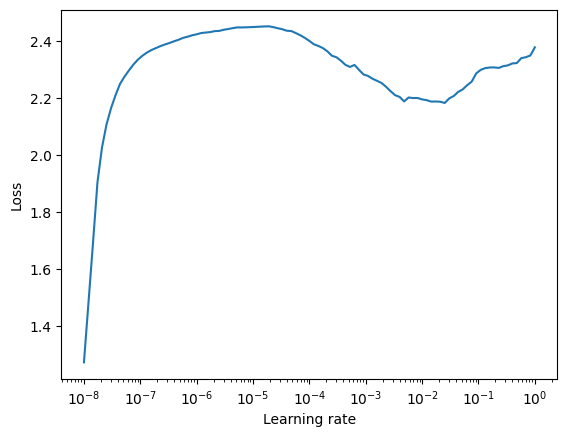

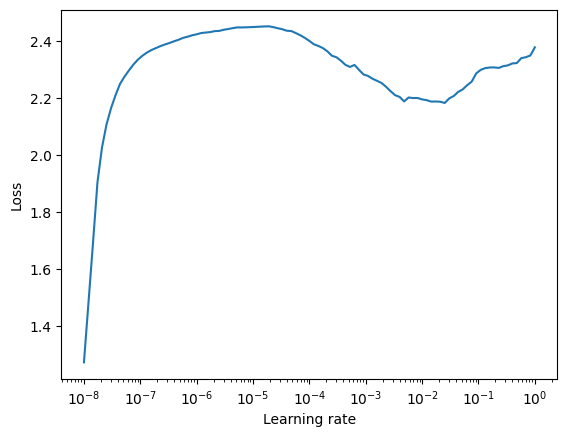

In [76]:
model = LResNet(resnet18, 3e-4) # will be overriden
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=5, log_every_n_steps=1)
tuner = pl.tuner.Tuner(trainer)
results = tuner.lr_find(model, train_loader)
results.plot()

From the graph, I'lll chose the starting value to be 1e-5 and the peak value to be 2e-3.

In [15]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, max_lr, min_lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.max_lr = max_lr
        self.min_lr = min_lr
        
        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

        self.img_scale = v2.ToDtype(torch.float32, scale=True)
        self.img_norm = v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
        self.img_aug = v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10)

    def training_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(self.img_aug(X)))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(X))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.min_lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr, epochs=30, steps_per_epoch=len(train_loader), div_factor=self.max_lr/self.min_lr)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

After testing and research, its probably best that we increase the max_epochs to something like 30 - it's a lot faster than the original one anyways. Running the below cell takes like less than 5 minutes while 10 epochs of the one above is also roughly similar.

In [33]:
model = LResNet(resnet18, 2e-3, 1e-5)
trainer = pl.Trainer(max_epochs=30, check_val_every_n_epoch=30, log_every_n_steps=1) 
trainer.fit(model, train_loader, test_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
2 | img_norm | Normalize          | 0      | train
3 | img_aug  | AutoAugment        | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [34]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.723800003528595     │
│         val_loss          │    0.8001051545143127     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8001051545143127, 'val_acc': 0.723800003528595}]

We're reaching the same performance as using smaller batches now! And it's still faster overall.

Next, we can just start with the biggest guns - using lower precision to train! The technical details are probably not helpful (using 16 bit in backward/forwards etc). The best is to use `bf16-mixed` if supported, which should speed up the process by a bit! However if it isn't available, `16-mixed` works too.

In [35]:
model = LResNet(resnet18, 2e-3, 1e-5)
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=30, check_val_every_n_epoch=30, log_every_n_steps=1) 
trainer.fit(model, train_loader, test_loader)

Using bfloat16 Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
2 | img_norm | Normalize          | 0      | train
3 | img_aug  | AutoAugment        | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [36]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7163000106811523     │
│         val_loss          │    0.8184337615966797     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8184337615966797, 'val_acc': 0.7163000106811523}]

Accuracy suffers slightly due to reduced precision... but this argument matters a lot more with larger models (like transformers) so I'll keep it! 

Next, let's try using torch's optimization features to improve the speed of running the model.

In [42]:
torch.backends.cudnn.benchmark = True # this allows cuda to choose the fastest operations
model = LResNet(resnet18, 2e-3, 1e-5)
# model = torch.compile(model) # fuse everything to get a modest speedup. however, compile really, really hates random augmentations in the model, so i don't do this.

In [43]:
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=30, check_val_every_n_epoch=30, log_every_n_steps=1) 
trainer.fit(model, train_loader, test_loader)

Using bfloat16 Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
2 | img_norm | Normalize          | 0      | train
3 | img_aug  | AutoAugment        | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [44]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.703000009059906     │
│         val_loss          │    0.8609970808029175     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8609970808029175, 'val_acc': 0.703000009059906}]

Wow, accuracy really tanking hard. I blame deterministic behaviour.  

Looking at the checklists, I realize this is basically all we can do for getting good speed - so let's just crank up the epochs one last time to see what the highest accuracy is! I'll give a deadline of maybe 15 minutes for training on this GPU (renting a 3060 right now) so we'll go for 100 epochs. I've also reduced the warmup epochs to 10% (instead of the default 30%) since we have the longer training schedule.  

I'll stopwatch the entire chunk of code from import to validation.

### The Final Code

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet18
import pytorch_lightning as pl
import torchmetrics
from torchvision.transforms import v2

In [2]:
img_transforms = v2.Compose([
    v2.ToImage(),
])

train_ds = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=img_transforms)
test_ds = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=img_transforms)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=4096, shuffle=True, num_workers=3, pin_memory=True, prefetch_factor=2, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=4096, shuffle=False, num_workers=3, pin_memory=True, prefetch_factor=2, persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

In [4]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, max_lr, min_lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.max_lr = max_lr
        self.min_lr = min_lr
        
        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

        self.img_scale = v2.ToDtype(torch.float32, scale=True)
        self.img_norm = v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
        self.img_aug = v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10)

    def training_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(self.img_aug(X)))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(X))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.min_lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr, epochs=100, steps_per_epoch=len(train_loader), div_factor=self.max_lr/self.min_lr, pct_start=0.1)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

In [5]:
model = LResNet(resnet18, 2e-3, 1e-5)
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=100, check_val_every_n_epoch=25, log_every_n_steps=5) 
trainer.fit(model, train_loader, test_loader)

Using bfloat16 Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [6]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7807999849319458     │
│         val_loss          │    0.7300027012825012     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7300027012825012, 'val_acc': 0.7807999849319458}]

Okay I actually missed the thing ending :( but I stopped the clock at 6 mins so overall this is still hella fast!!!

In [8]:
torch.save(model.resnet.state_dict(), "model.pth")